In [1]:
from src.densite_function import *
from src.gaussian_simulation import *
from src.estimators2 import *
from src.vraisemblance import *
import numpy as np
from numpy.linalg import norm
import matplotlib.pylab as plt


# Préalable

On fixe les paramètres optimaux $A$ et $b$ et on tire $\theta \sim \mathcal{N}(0,I_{20})$ selon le cadre expérimental décrit par Rainforth et al. (2018).
On reproduit le modèle génératif décrit par Y. Shi et R. Cornish, i.e $z \sim \mathcal{N}(\theta, I_{20})$ et $x \sim \mathcal{N}(z, I_{20}$)

In [2]:
np.random.seed(123)

theta=simulate_gaussian_vector(mu=np.array([0]*20), sigma=np.identity(20))
z=simulate_gaussian_vector(mu=theta, sigma=np.identity(20))
x=simulate_gaussian_vector(mu=z, sigma=np.identity(20)) #on sait simuler x|z

A=np.identity(20)*0.5
b=theta*0.5

# Estimateurs de la log-vraisemblance

## Comparaison entre estimateurs et vraie log-vraisemblance au point x

On prend $k=6$ pour l'estimateur IAWE, $l=0$ pour les autres, de sorte que le coût computationnel espéré de chaque estimateur soit de 6.

In [3]:
np.random.seed(123)
print("Vraie valeur de la log-vraisemblance au point x: {}".format(np.around(log_vraisemblance(x, theta), decimals=2)))
print("Estimateur IAWE de la log-vraisemblance: {}".format(np.around(importance_sampling_logvraisemblance(k=6, theta=theta, A=A, b=b, x=x), decimals=2)))
print("Estimateur SUMO de la log-vraisemblance: {}".format(np.around(estimateur_SUMO_logvraisemblance(theta=theta, A=A, b=b, x=x, r=0.6, l=0), decimals=2)))
print("Estimateur ML-SS de la log-vraisemblance: {}".format(np.around(estimateur_ML_SS_logvraisemblance(x, theta, A, b, r=0.6, l=0), decimals=2)))
print("Estimateur ML-RR de la log-vraisemblance: {}".format(np.around(estimateur_ML_RR_logvraisemblance(x, theta, A, b, r=0.6, l=0), decimals=2)))


Vraie valeur de la log-vraisemblance au point x: -37.99
Estimateur IAWE de la log-vraisemblance: -39.24
Estimateur SUMO de la log-vraisemblance: -38.24
Estimateur ML-SS de la log-vraisemblance: -39.08
Estimateur ML-RR de la log-vraisemblance: -38.23


On prend $k=12$ pour l'estimateur IAWE, $l=4$ pour le SUMO et $l=1$ pour les autres, de sorte que le coût computationnel espéré de chaque estimateur soit environ de 12.

In [4]:
np.random.seed(123)
print("Vraie valeur de la log-vraisemblance au point x: {}".format(np.around(log_vraisemblance(x, theta), decimals=2)))
print("Estimateur IAWE de la log-vraisemblance: {}".format(np.around(importance_sampling_logvraisemblance(k=12, theta=theta, A=A, b=b, x=x), decimals=2)))
print("Estimateur SUMO de la log-vraisemblance: {}".format(np.around(estimateur_SUMO_logvraisemblance(theta=theta, A=A, b=b, x=x, r=0.6, l=4), decimals=2)))
print("Estimateur ML-SS de la log-vraisemblance: {}".format(np.around(estimateur_ML_SS_logvraisemblance(x, theta, A, b, r=0.6, l=1), decimals=2)))
print("Estimateur ML-RR de la log-vraisemblance: {}".format(np.around(estimateur_ML_RR_logvraisemblance(x, theta, A, b, r=0.6, l=1), decimals=2)))

Vraie valeur de la log-vraisemblance au point x: -37.99
Estimateur IAWE de la log-vraisemblance: -38.01
Estimateur SUMO de la log-vraisemblance: -38.12
Estimateur ML-SS de la log-vraisemblance: -41.58
Estimateur ML-RR de la log-vraisemblance: -38.93


## Coût computationnel des estimateurs

On suppose que les estimateurs ML-SS, ML-RR et SUMO contiennent une période de chauffe $l$.
* IWAE: pour produire l'estimateur, on sample $k$ variables aléatoires. Le coût est déterministe: $\mathbb{E}[C_{IWAE}]=C_{IWAE}=k$
* ML-SS: pour produire l'estimateur, on sample $2^{K+l+1}$ variables aléatoires, où $K \sim \mathcal{G}(0,6) $. Donc $C_{ML-SS}=2^{K+l+1}$ est aléatoire.
$\mathbb{E}(C_{ML-SS})=6.2^l$
* ML-RR: pour produire l'estimateur, on sample $\sum_{k=0}^{K} 2^{k+l+1}$ variables. Donc $C_{ML-RR}=\sum_{k=0}^K 2^{k+l+1}$. $\mathbb{E}(C_{ML-RR})=6.2^l$
* SUMO: pour produire l'estimateur, on sample $\sum_{k=0}^K(k+l+2)=\frac{K(K+1)}{2}+(l+2)K$ variables. Donc, $C_{SUMO}=\frac{K(K+1)}{2}+(l+2)K$. $\mathbb{E}(C_{SUMO})=\frac{55}{9}+\frac{5}{3}l$

## Procédure de Monte Carlo

On met en place une procédure de Monte Carlo pour estimer le biais et la variance des estimateurs, en fonction du coût computationnel, pour chaque méthode.

L'algorithme est le suivant:

On note $l$: le paramètre de complexité computationnelle propre à chaque estimateur (le nombre de variables samplées pour IWAE, la période de chauffe pour les autres). On note $\mathbf{E}(C(l))$, le coût computationnel espéré pour $k$ fixé. On borne ce coût: $\mathbf{E}(C(l)) \in \{6, 12, 24,..., 384\}$.

Pour $l$ tel que $\mathbf{E}(C(l))=c \in \{6, 12, 24,..., 384\}$:

Pour m allant de 1 à M, faire:
* Générer $z \sim p_{\theta}(z)$
* Générer $x \sim p_{\theta}(x|z)$
* Calculer chaque estimateur au point $\mathbb{x}$: $estimateur_{m,l}$

Fin pour

Calculer:

\begin{equation}

    biais_{M,l}=\frac{1}{M} \sum_{m=1}^{M} estimateur_{m,l} - l(x;\theta)

\end{equation}

\begin{equation}

    Var_{M,l}=\frac{1}{M} \sum_{m=1}^{M}( estimateur_{m,l} - \frac{1}{M} \sum_{m=1}^{M} estimateur_{m,l})^{2}

\end{equation}


Fin pour

Retourner $biais_{M,l}, ..., Var_{M,l}$

Les auteurs de l'article prennent $M=1000$. Notons que comme le coût computationnel espéré de l'estimateur SUMO est linéaire (et non géométrique comme le ML-SS et le ML-RR), le paramètre $l$ est choisi à chaque itération tel que $\mathbb{E}(C_{SUMO})$ soit environ égal à la valeur $c$ désirée.

In [5]:
def procedure_MC_logvraisemblance(M, x, theta, A, b, L):

    biais_IWAE_M = {}
    biais_SUMO_M = {}
    biais_SS_M = {}
    biais_RR_M = {}

    var_IWAE_M = {}
    var_SUMO_M = {}
    var_SS_M = {}
    var_RR_M = {}

    l = 0
    while l <= L:
        m = 1
        estimations_IWAE_M_l = np.array([])
        estimations_SUMO_M_l = np.array([])
        estimations_SS_M_l = np.array([])
        estimations_RR_M_l = np.array([])

        while m <= M:
            z = simulate_gaussian_vector(mu=theta, sigma=np.identity(20))
            x = simulate_gaussian_vector(mu=z, sigma=np.identity(20))
            log_vraisemblance_estim_IWAE = importance_sampling_logvraisemblance(k=6*2**l, theta=theta, A=A, b=b, x=x)
            log_vraisemblance_estim_SUMO = estimateur_SUMO_logvraisemblance(theta=theta, A=A, b=b, x=x, r=0.6, l=l*38)
            log_vraisemblance_estim_SS = estimateur_ML_SS_logvraisemblance(theta=theta, A=A, b=b, x=x, r=0.6, l=l)
            log_vraisemblance_estim_RR = estimateur_ML_RR_logvraisemblance(theta=theta, A=A, b=b, x=x, r=0.6, l=l)

            estimations_IWAE_M_l = np.append(estimations_IWAE_M_l, log_vraisemblance_estim_IWAE)
            estimations_SUMO_M_l = np.append(estimations_SUMO_M_l, log_vraisemblance_estim_SUMO)
            estimations_SS_M_l = np.append(estimations_SS_M_l, log_vraisemblance_estim_SS)
            estimations_RR_M_l = np.append(estimations_RR_M_l, log_vraisemblance_estim_RR)
            m += 1

        biais_IWAE_M_l = np.mean(estimations_IWAE_M_l) -log_vraisemblance(x=x, theta=theta)
        biais_SUMO_M_l = np.mean(estimations_SUMO_M_l) -log_vraisemblance(x=x, theta=theta)
        biais_SS_M_l = np.mean(estimations_SS_M_l) - log_vraisemblance(x=x, theta=theta)
        biais_RR_M_l = np.mean(estimations_RR_M_l) - log_vraisemblance(x=x, theta=theta)

        var_IWAE_M_l = np.var(estimations_IWAE_M_l)
        var_SUMO_M_l = np.var(estimations_SUMO_M_l)
        var_SS_M_l = np.var(estimations_SS_M_l)
        var_RR_M_l = np.var(estimations_RR_M_l)

        biais_IWAE_M[l] = biais_IWAE_M_l
        biais_SUMO_M[l] = biais_SUMO_M_l
        biais_SS_M[l] = biais_SS_M_l
        biais_RR_M[l] = biais_RR_M_l

        var_IWAE_M[l] = var_IWAE_M_l
        var_SUMO_M[l] = var_SUMO_M_l
        var_SS_M[l] = var_SS_M_l
        var_RR_M[l] = var_RR_M_l

        l += 1

    return biais_IWAE_M, biais_SUMO_M, biais_SS_M, biais_RR_M, var_IWAE_M, var_SUMO_M, var_SS_M, var_RR_M


In [6]:
np.random.seed(123)

biais_IWAE_M, biais_SUMO_M, biais_SS_M, biais_RR_M, var_IWAE_M, var_SUMO_M, var_SS_M, var_RR_M = procedure_MC_logvraisemblance(M=1000,
                                                                                                                               L=6,
                                                                                                                               x=x,
                                                                                                                               theta=theta,
                                                                                                                               A=A,
                                                                                                                               b=b)


C:\Users\yanis\AppData\Local\Temp\ipykernel_29564\1494279517.py:25: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axs[0,0].plot(x_axis, np.square(biais_IAWE), 'b',
C:\Users\yanis\AppData\Local\Temp\ipykernel_29564\1494279517.py:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axs[0,0].plot(x_axis, np.square(biais_SUMO), 'b',
C:\Users\yanis\AppData\Local\Temp\ipykernel_29564\1494279517.py:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axs[0,0].plot(x_axis, np.square(biais_SS), 'b',
C:\Users\yanis\AppData\Local\Temp\ipykernel_29564\1494279517.py:31: UserWarning: color is redundantly defined by the 'color' keyw

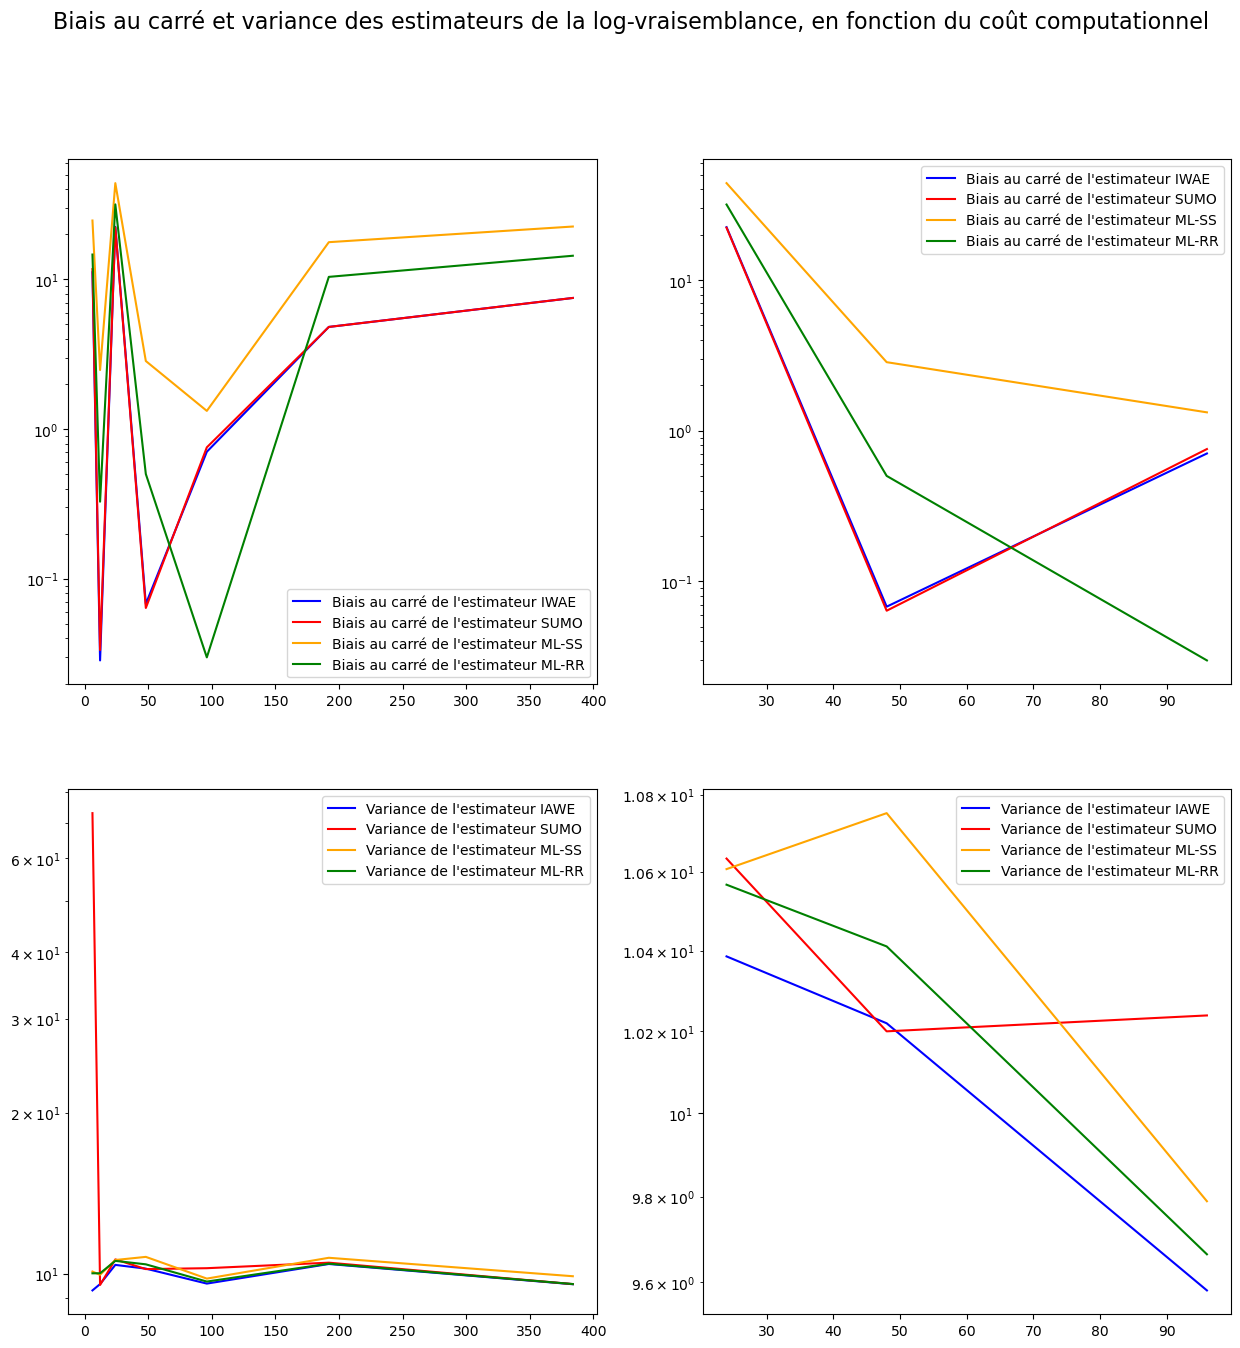

In [46]:
sorted_biais_IWAE_M = sorted(biais_IWAE_M.items())
sorted_biais_SUMO_M = sorted(biais_SUMO_M.items())
sorted_biais_SS_M = sorted(biais_SS_M.items())
sorted_biais_RR_M = sorted(biais_RR_M.items())

sorted_var_IWAE_M = sorted(var_IWAE_M.items())
sorted_var_SUMO_M = sorted(var_SUMO_M.items())
sorted_var_SS_M = sorted(var_SS_M.items())
sorted_var_RR_M = sorted(var_RR_M.items())

l, biais_IAWE = zip(*sorted_biais_IWAE_M)
l, biais_SUMO = zip(*sorted_biais_SUMO_M)
l, biais_SS = zip(*sorted_biais_SS_M)
l, biais_RR = zip(*sorted_biais_RR_M)

l, var_SUMO = zip(*sorted_var_SUMO_M)
l, var_SS = zip(*sorted_var_SS_M)
l, var_RR = zip(*sorted_var_RR_M)
l, var_IAWE = zip(*sorted_var_IWAE_M)

x_axis = [6*2**i for i in l]

fig, axs = plt.subplots(2, 2, figsize=(15, 15))

axs[0,0].plot(x_axis, np.square(biais_IAWE), 'b',
            label="Biais au carré de l'estimateur IWAE", color="blue")
axs[0,0].plot(x_axis, np.square(biais_SUMO), 'b',
            label="Biais au carré de l'estimateur SUMO", color="red")
axs[0,0].plot(x_axis, np.square(biais_SS), 'b',
            label="Biais au carré de l'estimateur ML-SS", color="orange")
axs[0,0].plot(x_axis, np.square(biais_RR), 'b',
            label="Biais au carré de l'estimateur ML-RR", color="green")

axs[0,0].legend()
axs[0,0].set_yscale("log")

axs[1,0].plot(x_axis, var_IAWE, 'b',
            label="Variance de l'estimateur IAWE", color="blue")
axs[1,0].plot(x_axis, var_SUMO, 'b',
            label="Variance de l'estimateur SUMO", color="red")
axs[1,0].plot(x_axis, var_SS, 'b',
            label="Variance de l'estimateur ML-SS", color="orange")
axs[1,0].plot(x_axis, var_RR, 'b',
            label="Variance de l'estimateur ML-RR", color="green")


axs[1,0].legend()
axs[1,0].set_yscale("log")


axs[0,1].plot(x_axis[2:5], np.square(biais_IAWE)[2:5], 'b',
            label="Biais au carré de l'estimateur IWAE", color="blue")
axs[0,1].plot(x_axis[2:5], np.square(biais_SUMO)[2:5], 'b',
            label="Biais au carré de l'estimateur SUMO", color="red")
axs[0,1].plot(x_axis[2:5], np.square(biais_SS)[2:5], 'b',
            label="Biais au carré de l'estimateur ML-SS", color="orange")
axs[0,1].plot(x_axis[2:5], np.square(biais_RR)[2:5], 'b',
            label="Biais au carré de l'estimateur ML-RR", color="green")

axs[0,1].legend()
axs[0,1].set_yscale("log")


axs[1,1].plot(x_axis[2:5], var_IAWE[2:5], 'b',
            label="Variance de l'estimateur IAWE", color="blue")
axs[1,1].plot(x_axis[2:5], var_SUMO[2:5], 'b',
            label="Variance de l'estimateur SUMO", color="red")
axs[1,1].plot(x_axis[2:5], var_SS[2:5], 'b',
            label="Variance de l'estimateur ML-SS", color="orange")
axs[1,1].plot(x_axis[2:5], var_RR[2:5], 'b',
            label="Variance de l'estimateur ML-RR", color="green")

axs[1,1].legend()
axs[1,1].set_yscale("log")

fig.suptitle('Biais au carré et variance des estimateurs de la log-vraisemblance, en fonction du coût computationnel', fontsize=16)

plt.show()


# Estimateurs du gradient de la log-vraisemblance

## Comparaison entre estimateurs et vrai gradient au point x

On estime le gradient de la log-vraisemblance au point $\mathbf{x}$. On prend $k=6$ pour l'estimateur IAWE, $l=0$ pour les autres, de sorte que le coût computationnel espéré de chaque estimateur soit de 6.

In [8]:
np.random.seed(123)
print("Vraie valeur du gradient de la log-vraisemblance au point x: {}".format(np.around(gradient_log_vraisemblance(x, theta), decimals=2)))
print("Estimateur IAWE du gradient de la log-vraisemblance: {}".format(np.around(importance_sampling_gradientlogvraisemblance(k=6, theta=theta, A=A, b=b, x=x), decimals=2)))
print("Estimateur SUMO du gradient de la log-vraisemblance: {}".format(np.around(estimateur_SUMO_gradientlogvraisemblance(theta=theta, A=A, b=b, x=x, r=0.6, l=0), decimals=2)))
print("Estimateur ML-SS du gradient de la log-vraisemblance: {}".format(np.around(estimateur_ML_SS_gradientlogvraisemblance(x, theta, A, b, r=0.6, l=0), decimals=2)))
print("Estimateur ML-RR du gradient de la log-vraisemblance: {}".format(np.around(estimateur_ML_RR_gradientlogvraisemblance(x, theta, A, b, r=0.6, l=0), decimals=2)))


Vraie valeur du gradient de la log-vraisemblance au point x: [-0.14 -0.47 -2.65  3.5  -1.83 -1.3   6.6  -2.03  1.68  2.75 -3.1  -7.67
 -0.06 -3.    1.91  1.79  1.79  4.89  1.23  2.71]
Estimateur IAWE du gradient de la log-vraisemblance: [ 0.03  0.08 -0.32  0.87 -0.28 -0.31  1.63 -1.13  0.61  0.65 -0.54 -2.85
  0.26 -0.99 -0.09  1.01  0.19  1.18  0.22  0.12]
Estimateur SUMO du gradient de la log-vraisemblance: [-0.02  1.45 -2.37  1.71 -0.31 -0.09  2.82 -1.7   1.46  0.99 -3.05 -3.75
  1.01 -2.98  0.78  0.36  0.84  3.37  0.64  0.76]
Estimateur ML-SS du gradient de la log-vraisemblance: [ 0.38 -0.75 -0.81  1.18 -1.22 -0.86  2.3  -0.84  0.32 -0.65  0.1  -2.97
  0.01 -0.07  0.4   0.01 -0.33  0.6   0.15  0.71]
Estimateur ML-RR du gradient de la log-vraisemblance: [ 0.4   0.28 -0.05 -2.19 -0.4   0.53  0.83 -1.72  2.9   2.06 -1.01 -5.02
  2.87 -1.38 -1.39  1.1   3.42  5.75  2.05  1.33]


On prend $k=12$ pour l'estimateur IAWE, $l=4$ pour le SUMO et $l=1$ pour les autres, de sorte que le coût computationnel espéré de chaque estimateur soit environ de 12.

In [9]:
np.random.seed(123)
print("Vraie valeur du gradient de la log-vraisemblance au point x: {}".format(np.around(gradient_log_vraisemblance(x, theta), decimals=2)))
print("Estimateur IAWE du gradient de la log-vraisemblance: {}".format(np.around(importance_sampling_gradientlogvraisemblance(k=12, theta=theta, A=A, b=b, x=x), decimals=2)))
print("Estimateur SUMO du gradient de la log-vraisemblance: {}".format(np.around(estimateur_SUMO_gradientlogvraisemblance(theta=theta, A=A, b=b, x=x, r=0.6, l=4), decimals=2)))
print("Estimateur ML-SS du gradient de la log-vraisemblance: {}".format(np.around(estimateur_ML_SS_gradientlogvraisemblance(x, theta, A, b, r=0.6, l=1), decimals=2)))
print("Estimateur ML-RR du gradient de la log-vraisemblance: {}".format(np.around(estimateur_ML_RR_gradientlogvraisemblance(x, theta, A, b, r=0.6, l=1), decimals=2)))


Vraie valeur du gradient de la log-vraisemblance au point x: [-0.14 -0.47 -2.65  3.5  -1.83 -1.3   6.6  -2.03  1.68  2.75 -3.1  -7.67
 -0.06 -3.    1.91  1.79  1.79  4.89  1.23  2.71]
Estimateur IAWE du gradient de la log-vraisemblance: [-0.2  -0.27 -0.18  1.18  0.05 -0.83  2.01 -0.92  0.33  0.63 -1.18 -2.01
 -0.43 -1.08  0.43  0.97  0.69  1.23  0.49  0.55]
Estimateur SUMO du gradient de la log-vraisemblance: [ 0.09 -0.39 -0.75  0.99 -1.13 -0.15  1.78 -0.28  0.29  0.57 -0.76 -2.11
  0.1  -1.56  0.56  0.45  0.42  1.41  0.42  0.59]
Estimateur ML-SS du gradient de la log-vraisemblance: [-0.29 -0.53 -0.91  1.12 -0.19 -0.39  1.27 -0.95  0.36  0.19 -0.08 -0.45
 -0.08 -0.76 -1.15  1.24 -0.46  0.61  0.66 -1.04]
Estimateur ML-RR du gradient de la log-vraisemblance: [ 1.21  0.59  0.38  0.36  0.05 -0.15  2.23 -0.04  0.74  1.27  0.26 -2.5
 -1.2  -0.5  -0.27  0.28  0.22  1.15  2.85  0.96]


## Procédure de Monte Carlo

On réplique la procédure précédente. Le gradient de la log-vraisemblance ainsi que les différents estimateurs associés sont dans $\mathbb{R}^{20}$. Ainsi, on adapte la définition du biais au carré et de la variance, de sorte à avoir une valeur réelle.

\begin{equation}

    biais_{M,l}=\frac{1}{M} \sum_{m=1}^{M} estimateur_{m,l} - \nabla_{\theta}l(x;\theta)

\end{equation}

\begin{equation}

    biais^2_{M,l}=\lVert biais_{M,l} \rVert^2

\end{equation}

\begin{equation}

    Var_{M,l}=\frac{1}{M} \sum_{m=1}^{M} \lVert estimateur_{m,l} - \frac{1}{M} \sum_{m=1}^{M} estimateur_{m,l} \rVert^{2}

\end{equation}

In [10]:
def procedure_MC_gradientlogvraisemblance(M, x, theta, A, b, L):

    biais_IWAE_M = {}
    biais_SUMO_M = {}
    biais_SS_M = {}
    biais_RR_M = {}

    var_IWAE_M = {}
    var_SUMO_M = {}
    var_SS_M = {}
    var_RR_M = {}

    l = 0
    while l <= L:
        m = 1
        estimations_IWAE_M_l = np.array([])
        estimations_SUMO_M_l = np.array([])
        estimations_SS_M_l = np.array([])
        estimations_RR_M_l = np.array([])

        while m <= M:
            z = simulate_gaussian_vector(mu=theta, sigma=np.identity(20))
            x = simulate_gaussian_vector(mu=z, sigma=np.identity(20))
            gradient_log_vraisemblance_estim_IWAE = importance_sampling_gradientlogvraisemblance(k=6*2**l, theta=theta, A=A, b=b, x=x)
            gradient_log_vraisemblance_estim_SUMO = estimateur_SUMO_gradientlogvraisemblance(theta=theta, A=A, b=b, x=x, r=0.6, l=l*38)
            gradient_log_vraisemblance_estim_SS = estimateur_ML_SS_gradientlogvraisemblance(theta=theta, A=A, b=b, x=x, r=0.6, l=l)
            gradient_log_vraisemblance_estim_RR = estimateur_ML_RR_gradientlogvraisemblance(theta=theta, A=A, b=b, x=x, r=0.6, l=l)
            
            if m == 1:
                estimations_IWAE_M_l = np.append(estimations_IWAE_M_l, gradient_log_vraisemblance_estim_IWAE)
                estimations_SUMO_M_l = np.append(estimations_SUMO_M_l, gradient_log_vraisemblance_estim_SUMO)
                estimations_SS_M_l = np.append(estimations_SS_M_l, gradient_log_vraisemblance_estim_SS)
                estimations_RR_M_l = np.append(estimations_RR_M_l, gradient_log_vraisemblance_estim_RR)

            else:
                estimations_IWAE_M_l = np.vstack((estimations_IWAE_M_l, gradient_log_vraisemblance_estim_IWAE))
                estimations_SUMO_M_l = np.vstack((estimations_SUMO_M_l, gradient_log_vraisemblance_estim_SUMO))
                estimations_SS_M_l = np.vstack((estimations_SS_M_l, gradient_log_vraisemblance_estim_SS))
                estimations_RR_M_l = np.vstack((estimations_RR_M_l, gradient_log_vraisemblance_estim_RR))
            m += 1

        biais_IWAE_M_l = np.mean(estimations_IWAE_M_l, axis=0)-gradient_log_vraisemblance(x=x, theta=theta)
        biais_SUMO_M_l = np.mean(estimations_SUMO_M_l, axis=0)-gradient_log_vraisemblance(x=x, theta=theta)
        biais_SS_M_l = np.mean(estimations_SS_M_l, axis=0)-gradient_log_vraisemblance(x=x, theta=theta)
        biais_RR_M_l = np.mean(estimations_RR_M_l, axis=0)-gradient_log_vraisemblance(x=x, theta=theta)

        squared_biais_IWAE_M_l = norm(biais_IWAE_M_l)**2
        squared_biais_SUMO_M_l = norm(biais_SUMO_M_l)**2
        squared_biais_SS_M_l = norm(biais_SS_M_l)**2
        squared_biais_RR_M_l = norm(biais_RR_M_l)**2

        var_IWAE_M_l = np.mean(norm(estimations_IWAE_M_l-np.mean(estimations_IWAE_M_l, axis=0), axis=1)**2)
        var_SUMO_M_l = np.mean(norm(estimations_SUMO_M_l-np.mean(estimations_SUMO_M_l, axis=0), axis=1)**2)
        var_SS_M_l = np.mean(norm(estimations_SS_M_l-np.mean(estimations_SS_M_l, axis=0), axis=1)**2)
        var_RR_M_l = np.mean(norm(estimations_RR_M_l-np.mean(estimations_RR_M_l, axis=0), axis=1)**2)

        biais_IWAE_M[l] = squared_biais_IWAE_M_l
        biais_SUMO_M[l] = squared_biais_SUMO_M_l
        biais_SS_M[l] = squared_biais_SS_M_l
        biais_RR_M[l] = squared_biais_RR_M_l

        var_IWAE_M[l] = var_IWAE_M_l
        var_SUMO_M[l] = var_SUMO_M_l
        var_SS_M[l] = var_SS_M_l
        var_RR_M[l] = var_RR_M_l

        l += 1

    return biais_IWAE_M, biais_SUMO_M, biais_SS_M, biais_RR_M, var_IWAE_M, var_SUMO_M, var_SS_M, var_RR_M


In [11]:
np.random.seed(123)

biais_IWAE_M_gradient, biais_SUMO_M_gradient, biais_SS_M_gradient, biais_RR_M_gradient, var_IWAE_M_gradient, var_SUMO_M_gradient, var_SS_M_gradient, var_RR_M_gradient = procedure_MC_gradientlogvraisemblance(M=1000,
                                                                                                                                                                                                               L=6,
                                                                                                                                                                                                               x=x,
                                                                                                                                                                                                               theta=theta,
                                                                                                                                                                                                               A=A,
                                                                                                                                                                                                               b=b)


C:\Users\yanis\AppData\Local\Temp\ipykernel_29564\2671275487.py:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axs[0,0].plot(x_axis, biais_IAWE_gradient, 'b',
C:\Users\yanis\AppData\Local\Temp\ipykernel_29564\2671275487.py:25: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axs[0,0].plot(x_axis, biais_SUMO_gradient, 'b',
C:\Users\yanis\AppData\Local\Temp\ipykernel_29564\2671275487.py:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axs[0,0].plot(x_axis, biais_SS_gradient, 'b',
C:\Users\yanis\AppData\Local\Temp\ipykernel_29564\2671275487.py:29: UserWarning: color is redundantly defined by the 'color' keyword ar

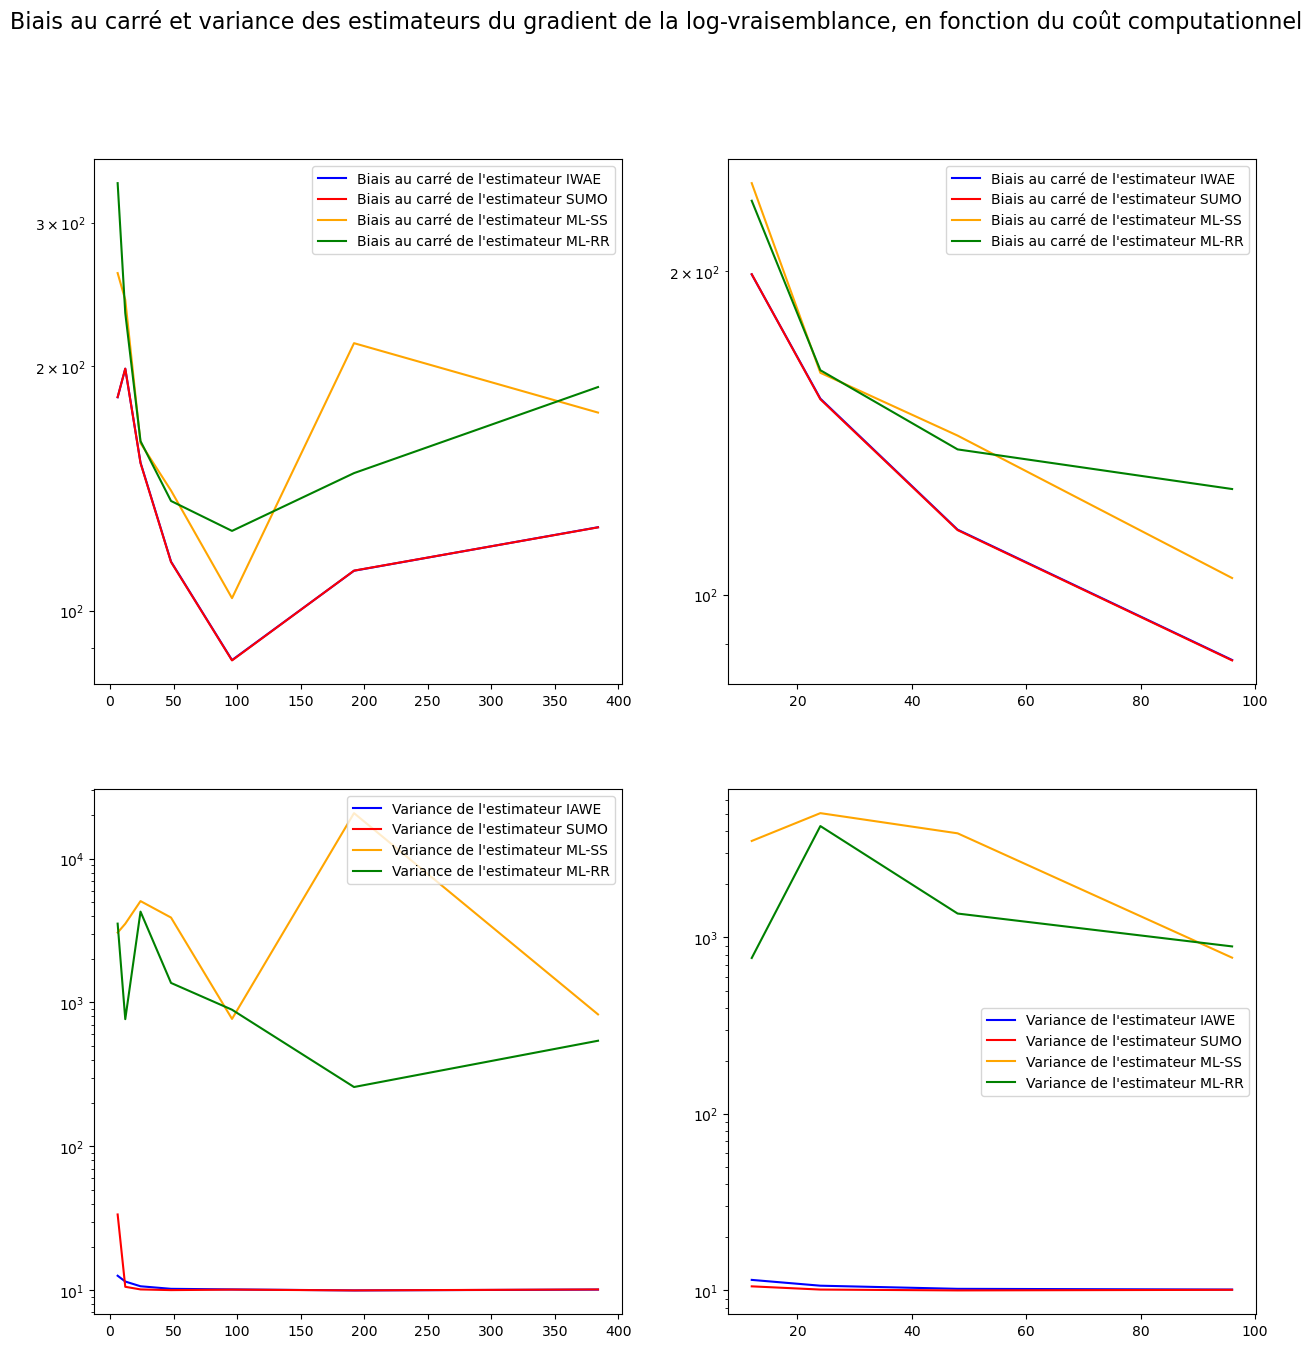

In [47]:
sorted_biais_IWAE_M_gradient = sorted(biais_IWAE_M_gradient.items())
sorted_biais_SUMO_M_gradient = sorted(biais_SUMO_M_gradient.items())
sorted_biais_SS_M_gradient = sorted(biais_SS_M_gradient.items())
sorted_biais_RR_M_gradient = sorted(biais_RR_M_gradient.items())

sorted_var_IWAE_M_gradient = sorted(var_IWAE_M_gradient.items())
sorted_var_SUMO_M_gradient = sorted(var_SUMO_M_gradient.items())
sorted_var_SS_M_gradient = sorted(var_SS_M_gradient.items())
sorted_var_RR_M_gradient = sorted(var_RR_M_gradient.items())

l, biais_IAWE_gradient = zip(*sorted_biais_IWAE_M_gradient)
l, biais_SUMO_gradient = zip(*sorted_biais_SUMO_M_gradient)
l, biais_SS_gradient = zip(*sorted_biais_SS_M_gradient)
l, biais_RR_gradient = zip(*sorted_biais_RR_M_gradient)

l, var_IAWE_gradient = zip(*sorted_var_IWAE_M_gradient)
l, var_SUMO_gradient = zip(*sorted_var_SUMO_M_gradient)
l, var_SS_gradient = zip(*sorted_var_SS_M_gradient)
l, var_RR_gradient = zip(*sorted_var_RR_M_gradient)

fig, axs = plt.subplots(2, 2, figsize=(15, 15))

axs[0,0].plot(x_axis, biais_IAWE_gradient, 'b',
            label="Biais au carré de l'estimateur IWAE", color="blue")
axs[0,0].plot(x_axis, biais_SUMO_gradient, 'b',
            label="Biais au carré de l'estimateur SUMO", color="red")
axs[0,0].plot(x_axis, biais_SS_gradient, 'b',
            label="Biais au carré de l'estimateur ML-SS", color="orange")
axs[0,0].plot(x_axis, biais_RR_gradient, 'b',
            label="Biais au carré de l'estimateur ML-RR", color="green")

axs[0,0].set_yscale("log")

axs[0,0].legend()

axs[0,1].plot(x_axis[1:5], biais_IAWE_gradient[1:5], 'b',
            label="Biais au carré de l'estimateur IWAE", color="blue")
axs[0,1].plot(x_axis[1:5], biais_SUMO_gradient[1:5], 'b',
            label="Biais au carré de l'estimateur SUMO", color="red")
axs[0,1].plot(x_axis[1:5], biais_SS_gradient[1:5], 'b',
            label="Biais au carré de l'estimateur ML-SS", color="orange")
axs[0,1].plot(x_axis[1:5], biais_RR_gradient[1:5], 'b',
            label="Biais au carré de l'estimateur ML-RR", color="green")

axs[0,1].set_yscale("log")

axs[0,1].legend()

fig.suptitle('Biais au carré et variance des estimateurs du gradient de la log-vraisemblance, en fonction du coût computationnel', fontsize=16)

axs[1,0].plot(x_axis, var_IAWE_gradient, 'b',
            label="Variance de l'estimateur IAWE", color="blue")
axs[1,0].plot(x_axis, var_SUMO_gradient, 'b',
            label="Variance de l'estimateur SUMO", color="red")
axs[1,0].plot(x_axis, var_SS_gradient, 'b',
            label="Variance de l'estimateur ML-SS", color="orange")
axs[1,0].plot(x_axis, var_RR_gradient, 'b',
            label="Variance de l'estimateur ML-RR", color="green")

axs[1,0].set_yscale("log")

axs[1,0].legend()

axs[1,1].plot(x_axis[1:5], var_IAWE_gradient[1:5], 'b',
            label="Variance de l'estimateur IAWE", color="blue")
axs[1,1].plot(x_axis[1:5], var_SUMO_gradient[1:5], 'b',
            label="Variance de l'estimateur SUMO", color="red")
axs[1,1].plot(x_axis[1:5], var_SS_gradient[1:5], 'b',
            label="Variance de l'estimateur ML-SS", color="orange")
axs[1,1].plot(x_axis[1:5], var_RR_gradient[1:5], 'b',
            label="Variance de l'estimateur ML-RR", color="green")

axs[1,1].set_yscale("log")

axs[1,1].legend()


plt.show()

In [52]:
# %store biais_IWAE_M
# %store biais_SUMO_M
# %store biais_SS_M
# %store biais_RR_M
# %store var_IWAE_M
# %store var_SUMO_M
# %store var_SS_M
# %store var_RR_M

# %store biais_IWAE_M_gradient
# %store biais_SUMO_M_gradient
# %store biais_SS_M_gradient
# %store biais_RR_M_gradient
# %store var_IWAE_M_gradient
# %store var_SUMO_M_gradient
# %store var_SS_M_gradient
# %store var_RR_M_gradient

Stored 'biais_IWAE_M' (dict)
Stored 'biais_SUMO_M' (dict)
Stored 'biais_SS_M' (dict)
Stored 'biais_RR_M' (dict)
Stored 'var_IWAE_M' (dict)
Stored 'var_SUMO_M' (dict)
Stored 'var_SS_M' (dict)
Stored 'var_RR_M' (dict)
Stored 'biais_IWAE_M_gradient' (dict)
Stored 'biais_SUMO_M_gradient' (dict)
Stored 'biais_SS_M_gradient' (dict)
Stored 'biais_RR_M_gradient' (dict)
Stored 'var_IWAE_M_gradient' (dict)
Stored 'var_SUMO_M_gradient' (dict)
Stored 'var_SS_M_gradient' (dict)
Stored 'var_RR_M_gradient' (dict)
